# loading a covering grid as a uniform grid dataset

given a particle dataset:

1. create a covering grid
2. re-load that covering grid as a full dataset
3. create some slices, etc. 

useful: https://yt-project.org/doc/analyzing/fields.html#sph-fields 


In [1]:
import yt
import numpy as np

ds = yt.load_sample("gizmo_64")
v, c = ds.find_max("Density")

yt : [INFO     ] 2024-06-26 09:54:38,889 Sample dataset found in '/home/chavlin/hdd/data/yt_data/yt_sample_sets/gizmo_64/output/snap_N64L16_135.hdf5'
yt : [INFO     ] 2024-06-26 09:54:38,974 ComovingIntegrationOn does not exist, falling back to OmegaLambda
yt : [INFO     ] 2024-06-26 09:54:38,984 Calculating time from 1.000e+00 to be 4.250e+17 seconds
yt : [INFO     ] 2024-06-26 09:54:38,985 Assuming length units are in kpc/h (comoving)
yt : [INFO     ] 2024-06-26 09:54:39,051 Parameters: current_time              = 4.2498606916019354e+17 s
yt : [INFO     ] 2024-06-26 09:54:39,052 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2024-06-26 09:54:39,052 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-06-26 09:54:39,053 Parameters: domain_right_edge         = [16000. 16000. 16000.]
yt : [INFO     ] 2024-06-26 09:54:39,053 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2024-06-26 09:54:39,053 Parameters: current_redshift          = 4

Create a covering grid and extract some interpolated values (see https://yt-project.org/doc/analyzing/fields.html#sph-fields): 

In [38]:
cg = ds.r[::256j, ::256j, ::256j]
data = {}
for field in [('gas', 'density'), ('gas', 'temperature')]: 
    data[field] = cg[field]

Interpolating SPH field ('PartType0', 'Density'): 500000it [00:08, 62193.10it/s]
Interpolating SPH field ('PartType0', 'Temperature'): 500000it [00:08, 61876.17it/s]


those values are uniform 3d arrays. 

In [39]:
data['gas', 'density'].shape

(256, 256, 256)

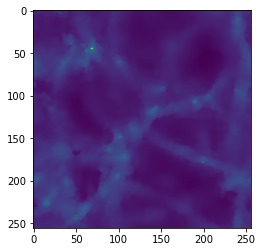

In [40]:
import matplotlib.pyplot as plt 

plt.imshow(np.log10(data['gas','density'][:,:,64]))

but we want to be able to use these arrays with yt's full api. I've had mixed success with the `save_as_dataset` function... but it's pretty easy to just use `yt.load_uniform_grid`: 



In [41]:
bbox = np.column_stack([cg.LeftEdge, cg.RightEdge])

ds_grid = yt.load_uniform_grid(data, 
                               cg.ActiveDimensions, 
                               length_unit=ds.length_unit,
                               velocity_unit=ds.velocity_unit, 
                               time_unit=ds.time_unit,
                               bbox=bbox)
ds_grid.field_list

yt : [INFO     ] 2024-06-26 10:05:31,011 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-06-26 10:05:31,011 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2024-06-26 10:05:31,012 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-06-26 10:05:31,013 Parameters: domain_right_edge         = [16000. 16000. 16000.]
yt : [INFO     ] 2024-06-26 10:05:31,013 Parameters: cosmological_simulation   = 0


[('gas', 'density'), ('gas', 'temperature')]

In [42]:
c.to('Mpc')

unyt_array([14.87443778,  2.79089844,  6.89955497], 'Mpc')

In [43]:
ds_grid.domain_left_edge

standard slice plot, setting center from the max density location found earlier:

yt : [INFO     ] 2024-06-26 10:07:59,857 xlim = 2412.106445 18412.106445
yt : [INFO     ] 2024-06-26 10:07:59,859 ylim = -6046.371094 9953.628906
yt : [INFO     ] 2024-06-26 10:07:59,862 xlim = 2412.106445 18412.106445
yt : [INFO     ] 2024-06-26 10:07:59,862 ylim = -6046.371094 9953.628906
yt : [INFO     ] 2024-06-26 10:07:59,863 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



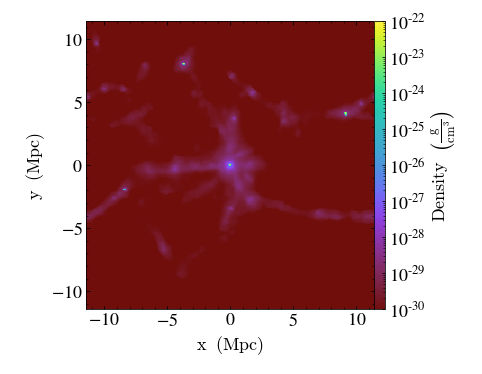

In [55]:
slc = yt.SlicePlot(ds_grid, 'z', ("gas", "density"), center = c.to('Mpc'), window_size=(4,4))
slc.set_zlim(('gas', 'density'), 1e-30, 1e-22)
slc.show()

yt : [INFO     ] 2024-06-26 10:12:09,718 Projection completed
yt : [INFO     ] 2024-06-26 10:12:09,719 xlim = 0.000000 16000.000000
yt : [INFO     ] 2024-06-26 10:12:09,720 ylim = 0.000000 16000.000000
yt : [INFO     ] 2024-06-26 10:12:09,722 xlim = 0.000000 16000.000000
yt : [INFO     ] 2024-06-26 10:12:09,723 ylim = 0.000000 16000.000000
yt : [INFO     ] 2024-06-26 10:12:09,723 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



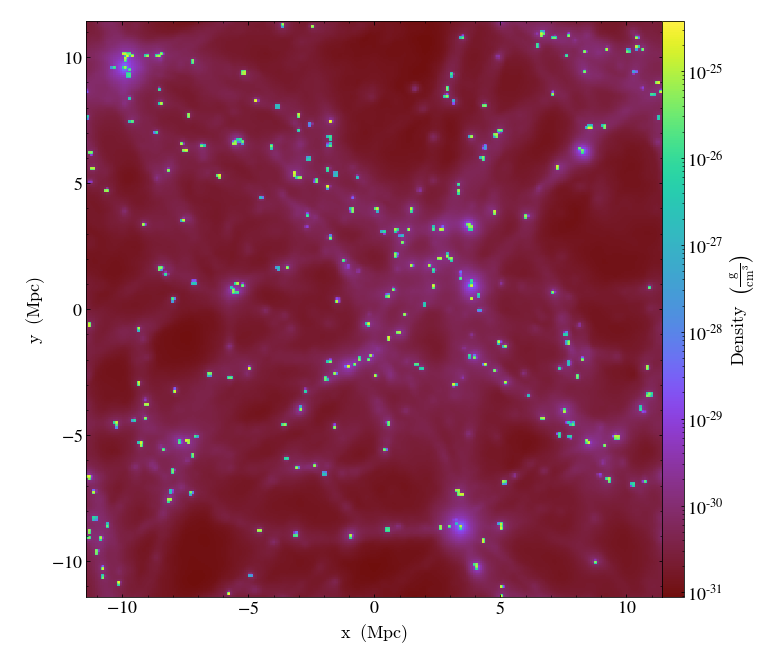

In [63]:
grid_proj = yt.ProjectionPlot(ds_grid, 'z', ("gas", "density"), weight_field=('index','cell_volume'))
# grid_proj.set_zlim(('gas', 'density'), 1e-30, 1)
grid_proj.show()

yt : [INFO     ] 2024-06-26 10:08:45,174 xlim = 2412.106445 18412.106445
yt : [INFO     ] 2024-06-26 10:08:45,175 ylim = -6046.371094 9953.628906
yt : [INFO     ] 2024-06-26 10:08:45,177 xlim = 2412.106445 18412.106445
yt : [INFO     ] 2024-06-26 10:08:45,178 ylim = -6046.371094 9953.628906
yt : [INFO     ] 2024-06-26 10:08:45,179 Splatting (('gas', 'density')) onto a 800 by 800 mesh using method 'ngp'



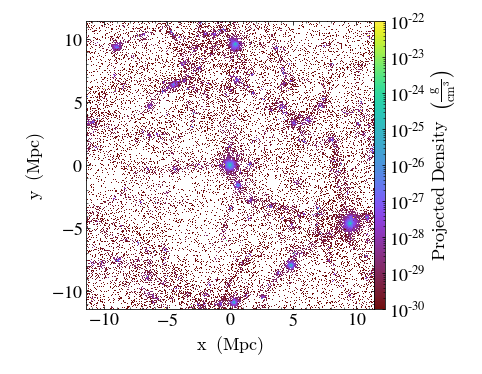

In [57]:
pp = yt.ParticlePlot(ds, 
                ('PartType0','particle_position_x'), 
                ('PartType0','particle_position_y'), 
                ('gas', 'density'), 
                 center=c.to('Mpc'),
                 window_size=(4,4))
pp.set_zlim(('gas', 'density'), 1e-30, 1e-22)

off-axis plot in the z-plane (swapping axes here to make it match the default view above):

yt : [INFO     ] 2024-06-26 10:02:45,156 xlim = -7000.000000 7000.000000
yt : [INFO     ] 2024-06-26 10:02:45,157 ylim = -7000.000000 7000.000000
yt : [INFO     ] 2024-06-26 10:02:45,158 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



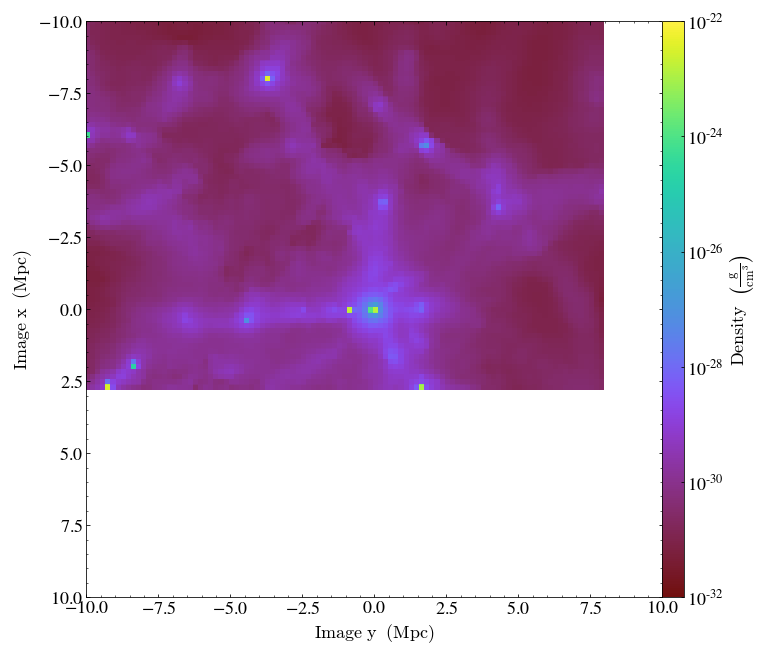

In [31]:
slc = yt.OffAxisSlicePlot(ds_grid, np.array([0, 0.001, 1]), ("gas", "density"), center=c.to('Mpc'), width=(20, 'Mpc'))
slc.set_zlim(('gas', 'density'), 1e-32, 1e-22)
slc.swap_axes()
slc.flip_vertical()
slc.show()